In [1]:
import mysql.connector as sql
import pandas as pd
import datetime as dt
import numpy as np
from sorted_months_weekdays import *
from sort_dataframeby_monthorweek import *
import matplotlib.pyplot as plt
import math
import requests
import json
from pandas.io.json import json_normalize
import matplotlib.dates as mdates
from datetime import date, timedelta
from requests.packages.urllib3.util.retry import Retry

In [2]:
db_connection = sql.connect(host='localhost', database='collection_users', user='pandas', password='password')
sbItems = pd.read_sql('SELECT * FROM UsersShoeboxItems', con=db_connection)
sbItems['tool_id'] = sbItems['tool_id'].astype('category')
sbItems['extension'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['extension'] = sbItems['extension'].astype('category')
sbItems['mimetype'] = sbItems['mimetype'].astype('category')
sbItems['created'] = pd.to_datetime(sbItems['created'], unit='s')
sbItems['lastmodified'] = pd.to_datetime(sbItems['lastmodified'], unit='s')
sbItems['deleted'].replace(0, np.nan, inplace=True)
sbItems['deleted'] = pd.to_datetime(sbItems['deleted'], unit='s')
# sbItems['refers_to_uid'].replace(0, np.nan, inplace=True)
sbItems['refers_to_uid'] = sbItems['refers_to_uid'].astype(int)
sbItems['fingerprint'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['title'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['description'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['secret'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['secret_o'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)
sbItems['extras'].replace(r'^\s*$', np.NaN, regex=True, inplace=True)

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
pd.set_option("max_colwidth", 500)

In [4]:
url = 'https://api.collection.cooperhewitt.org/rest/?method=cooperhewitt.objects.getInfo&access_token=729cca8ffeb40cd2e725f5301e034134&object_id=69155331'
resp = requests.request('GET', url)
resp

<Response [200]>

In [5]:
resp.status_code

200

In [6]:
items = json.loads(resp.text)
items = pd.json_normalize(items)
items

,stat,event_publishing_state,object.id,object.tms:id,object.accession_number,object.title,object.title_raw,object.url,object.has_no_known_copyright,object.department_id,object.period_id,object.media_id,object.type_id,object.date,object.year_start,object.year_end,object.year_acquired,object.decade,object.woe:country_id,object.medium,object.markings,object.signed,object.inscribed,object.provenance,object.dimensions,object.dimensions_raw,object.creditline,object.description,object.justification,object.gallery_text,object.label_text,object.videos,object.on_display,object.woe:country,object.type,object.images,object.participants,object.is_loan_object
0,ok,ok,69155331,282992,"7.2015.1a,b","Scale Models, Architecture is Everywhere, 2015",Architecture is Everywhere,https://collection.cooperhewitt.org/objects/69155331/,None,404529577,None,420568395,420560743,2015,2015,2015,None,2010,None,"wood, aluminum, ceramic, dried flowers, fabric, paper, plastic, sponge, stainless steel",None,None,None,None,H x W x D (each): 10 × 15 × 15 cm (3 15/16 × 5 7/8 × 5 7/8 in.) (approx.),None,Courtesy of Sou Fujimoto Architects,None,None,"Sou Fujimoto Architects created this series of models for the 2015 Chicago Architecture Biennial. Called Architecture Is Everywhere, the project discovers architectural possibility in found objects and everyday materials. Simple artifacts such as a lottery ticket, an ashtray, or a ring of binder clips become intriguing structures when placed on pedestals with tiny human figures. In the words of Sou Fujimoto, “This is kind of a funny trial to expand our ideas of architecture beyond our usual...",None,None,None,None,Scale models,"[{'b': {'url': 'https://images.collection.cooperhewitt.org/269364_5f9ebc42b614bc22_b.jpg', 'width': 1024, 'height': 644, 'is_primary': '1', 'image_id': '269364'}, 'z': {'url': 'https://images.collection.cooperhewitt.org/269364_5f9ebc42b614bc22_z.jpg', 'width': 640, 'height': 402, 'is_primary': '1', 'image_id': '269364'}, 'n': {'url': 'https://images.collection.cooperhewitt.org/269364_5f9ebc42b614bc22_n.jpg', 'width': 320, 'height': 201, 'is_primary': '1', 'image_id': '269364'}, 'd': {'url': ...","[{'person_id': '69154757', 'role_id': '35236655', 'person_name': 'Sou Fujimoto Architects', 'person_date': 'Tokyo, Japan, founded 2000', 'role_name': 'Designer', 'role_display_name': 'Designed by', 'person_url': 'https://collection.cooperhewitt.org/people/69154757/', 'role_url': 'https://collection.cooperhewitt.org/roles/35236655/'}, {'person_id': '69154757', 'role_id': '51571131', 'person_name': 'Sou Fujimoto Architects', 'person_date': 'Tokyo, Japan, founded 2000', 'role_name': 'Lender', '...",1


In [51]:
popular = sbItems['refers_to_uid'].value_counts().nlargest(300)
popular


18703475    4362
18703477    4256
18703473    4159
18703503    3942
35460287    3633
            ... 
69192511    1101
18447273    1101
69192515    1100
69155051    1098
51689425    1098
Name: refers_to_uid, Length: 300, dtype: int64

In [18]:
def fetch_URL(url):
    session = requests.Session()
    retry = Retry(connect = 3, backoff_factor = 0.5)
    adapter = requests.adapters.HTTPAdapter(max_retries = retry)
    session.mount('https://', adapter)
    
    return session.get(url)

In [19]:
popular_items = popular.index.astype(str)
items_info = None
errs = []
for item in popular_items:
    try:
        url = 'https://api.collection.cooperhewitt.org/rest/?method=cooperhewitt.objects.getInfo&access_token=729cca8ffeb40cd2e725f5301e034134&object_id=' + item
#         resp = requests.request('GET', url)
        resp = fetch_URL(url)
        items = json.loads(resp.text)
        items = pd.json_normalize(items)
        if items_info is None:
            items_info = items
        else:
            items_info = pd.concat([items_info, items])
    except RuntimeError as e:
        errs.append(e)
items_info

# 300 popular items

,stat,event_publishing_state,object.id,object.tms:id,object.accession_number,object.title,object.title_raw,object.url,object.has_no_known_copyright,object.department_id,object.period_id,object.media_id,object.type_id,object.date,object.year_start,object.year_end,object.year_acquired,object.decade,object.woe:country_id,object.medium,object.markings,object.signed,object.inscribed,object.provenance,object.dimensions,object.dimensions_raw.depth,object.dimensions_raw.height,object.dimensions_raw.width,object.creditline,object.description,object.justification,object.gallery_text,object.label_text,object.videos,object.on_display,object.woe:country,object.type,object.images,object.participants,object.woe:country_name,object.is_loan_object,object.dimensions_raw.diameter,object.dimensions_raw,error.code,error.error,error.message,object.dimensions_raw.length,object.dimensions_raw.warp,object.dimensions_raw.weft
0,ok,ok,18703475,227515,2007-45-11,"Staircase Model (France), late 18th century",,https://collection.cooperhewitt.org/objects/18703475/,None,35347497,None,2318799985,35302429,late 18th century,None,None,2007,None,23424819,"pear, brass wire, bone",None,None,None,Eugene V. and Clare E. Thaw; 2007: acquired by Museum,H x W x D: 75 x 67.3 x 67 cm (29 1/2 x 26 1/2 x 26 3/8 in.),"[67.00, centimeters]","[75.00, centimeters]","[67.30, centimeters]",Gift of Eugene V. and Clare E. Thaw,Double-revolution super-imposed staircase model.,None,None,This fine triple-height staircase model is similar to one designed by Robert Adam for 20 Portman Place in London. The model’s sustaining pillars ensure stability in place of the walls used in Adam’s staircase. The pillars are joined in a manner characteristic of a builder rather than a compagnonnage-trained cabinetmaker.,None,None,23424819,Staircase model,"[{'b': {'url': 'https://images.collection.cooperhewitt.org/90933_71d437d4fe573bab_b.jpg', 'width': 1024, 'height': 1024, 'is_primary': '1', 'image_id': '90933'}, 'z': {'url': 'https://images.collection.cooperhewitt.org/90933_71d437d4fe573bab_z.jpg', 'width': 640, 'height': 640, 'is_primary': '1', 'image_id': '90933'}, 'n': {'url': 'https://images.collection.cooperhewitt.org/90933_71d437d4fe573bab_n.jpg', 'width': 320, 'height': 320, 'is_primary': '1', 'image_id': '90933'}, 'sq': {'url': 'htt...","[{'person_id': '68736639', 'role_id': '2318792694', 'person_name': 'Eugene V. Thaw', 'person_date': '', 'role_name': 'Previous owner', 'role_display_name': 'Previously owned by', 'person_url': 'https://collection.cooperhewitt.org/people/68736639/', 'role_url': 'https://collection.cooperhewitt.org/roles/2318792694/'}, {'person_id': '68736639', 'role_id': '35351535', 'person_name': 'Eugene V. Thaw', 'person_date': '', 'role_name': 'Donor', 'role_display_name': 'Donated by', 'person_url': 'http...",France,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,ok,ok,18703477,227516,2007-45-12,"Staircase Model (France), early 19th century",,https://collection.cooperhewitt.org/objects/18703477/,None,35347497,None,2318799986,35302429,early 19th century,None,None,2007,None,23424819,"mahogany, ebony, pear or sycamore, oak; biscuit porcelain",None,None,None,Eugene V. and Clare E. Thaw; 2007: acquired by Museum,H x W x D: 68 x 48.3 x 41 cm (26 3/4 in. x 19 in. x 16 1/8 in.),"[41.00, centimeters]","[68.00, centimeters]","[48.30, centimeters]",Gift of Eugene V. and Clare E. Thaw,"Model of a curved double staircase reaching a landing and continuing up as a single stair; steps and risers inlaid in contrasting wood to emulate carpet; busts of Francois-Marie Arouet, called Voltaire (1694-1778), and Jean-Jacques Rousseau (1712-1778) made of Sèvres biscuit porcelain on newel posts at top.",None,None,"This double revolution staircase is unmistakably a masterwork, confirmed by details such as the carefully turned, ebony balusters and the sophisticated veneering used to create an inlaid “carpet.” A hint of revolutionary politics is introduced through a juxtaposition of Sèvres biscuit porcelain b

In [57]:
def fetch_exhibition(object_id):
    url_exhibition = 'https://api.collection.cooperhewitt.org/rest/?method=cooperhewitt.objects.getExhibitions&access_token=729cca8ffeb40cd2e725f5301e034134&id=' + str(object_id)
    resp = fetch_URL(url_exhibition)
    exhibition_object = json.loads(resp.text)
    if exhibition_object.get('count_exhibitions', 0) == 0:
        return None
    exhibition_object_id = exhibition_object['object_id']
    exhibition_id = exhibition_object['exhibitions'][0]['id']
    exhibition_title = exhibition_object['exhibitions'][0]['title']
    exhibition_date_start = exhibition_object['exhibitions'][0]['date_start']
    exhibition_date_end = exhibition_object['exhibitions'][0]['date_end']
    exhibition_results = [{'exhibition_object_id': exhibition_object_id,'exhibition_id': exhibition_id, 'exhibition_title': exhibition_title, 
                           'exhibition_date_start': exhibition_date_start, 'exhibition_date_end': exhibition_date_end}]
    return pd.DataFrame(exhibition_results)
    
fetch_exhibition(18703475)


,exhibition_object_id,exhibition_id,exhibition_title,exhibition_date_start,exhibition_date_end
0,18703475,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03


In [58]:
popular_items = popular.index.astype(str)

object_exhibition = None
errs = []

for item in popular_items:
    try:
        exhibition_data = fetch_exhibition(item)
        if exhibition_data is None:
            continue
        if object_exhibition is None:
            object_exhibition = exhibition_data
        else:
            object_exhibition = pd.concat([object_exhibition, exhibition_data])
    except RuntimeError as e:
        errs.append(e)
object_exhibition

,exhibition_object_id,exhibition_id,exhibition_title,exhibition_date_start,exhibition_date_end
0,18703475,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03
0,18703477,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03
0,18703473,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03
0,18703503,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03
0,18703485,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03
...,...,...,...,...,...
0,69192511,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21
0,18447273,51668983,Making Design,2014-12-12,2016-09-01
0,69192515,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21
0,69155051,69155413,Beauty—Cooper Hewitt Design Triennial,2016-02-12,2016-08-21


# to join by date

In [61]:
object_exhibition.rename({'exhibition_object_id': 'object_id'}, axis=1, inplace=True)

In [64]:
items_info.rename({'object.id': 'object_id'}, axis=1, inplace=True)

In [78]:
merged_date = object_exhibition.merge(items_info, on='object_id', suffixes=('_item_info', '_exhibition'))
merged_date

,object_id,exhibition_id,exhibition_title,exhibition_date_start,exhibition_date_end,stat,event_publishing_state,object.tms:id,object.accession_number,object.title,object.title_raw,object.url,object.has_no_known_copyright,object.department_id,object.period_id,object.media_id,object.type_id,object.date,object.year_start,object.year_end,object.year_acquired,object.decade,object.woe:country_id,object.medium,object.markings,...,object.dimensions,object.dimensions_raw.depth,object.dimensions_raw.height,object.dimensions_raw.width,object.creditline,object.description,object.justification,object.gallery_text,object.label_text,object.videos,object.on_display,object.woe:country,object.type,object.images,object.participants,object.woe:country_name,object.is_loan_object,object.dimensions_raw.diameter,object.dimensions_raw,error.code,error.error,error.message,object.dimensions_raw.length,object.dimensions_raw.warp,object.dimensions_raw.weft
0,18703475,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03,ok,ok,227515,2007-45-11,"Staircase Model (France), late 18th century",,https://collection.cooperhewitt.org/objects/18703475/,None,35347497,None,2318799985,35302429,late 18th century,None,None,2007,None,23424819,"pear, brass wire, bone",None,...,H x W x D: 75 x 67.3 x 67 cm (29 1/2 x 26 1/2 x 26 3/8 in.),"[67.00, centimeters]","[75.00, centimeters]","[67.30, centimeters]",Gift of Eugene V. and Clare E. Thaw,Double-revolution super-imposed staircase model.,None,None,This fine triple-height staircase model is similar to one designed by Robert Adam for 20 Portman Place in London. The model’s sustaining pillars ensure stability in place of the walls used in Adam’s staircase. The pillars are joined in a manner characteristic of a builder rather than a compagnonnage-trained cabinetmaker.,None,None,23424819,Staircase model,"[{'b': {'url': 'https://images.collection.cooperhewitt.org/90933_71d437d4fe573bab_b.jpg', 'width': 1024, 'height': 1024, 'is_primary': '1', 'image_id': '90933'}, 'z': {'url': 'https://images.collection.cooperhewitt.org/90933_71d437d4fe573bab_z.jpg', 'width': 640, 'height': 640, 'is_primary': '1', 'image_id': '90933'}, 'n': {'url': 'https://images.collection.cooperhewitt.org/90933_71d437d4fe573bab_n.jpg', 'width': 320, 'height': 320, 'is_primary': '1', 'image_id': '90933'}, 'sq': {'url': 'htt...","[{'person_id': '68736639', 'role_id': '2318792694', 'person_name': 'Eugene V. Thaw', 'person_date': '', 'role_name': 'Previous owner', 'role_display_name': 'Previously owned by', 'person_url': 'https://collection.cooperhewitt.org/people/68736639/', 'role_url': 'https://collection.cooperhewitt.org/roles/2318792694/'}, {'person_id': '68736639', 'role_id': '35351535', 'person_name': 'Eugene V. Thaw', 'person_date': '', 'role_name': 'Donor', 'role_display_name': 'Donated by', 'person_url': 'http...",France,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,18703477,35350895,Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,2006-10-13,2007-06-03,ok,ok,227516,2007-45-12,"Staircase Model (France), early 19th century",,https://collection.cooperhewitt.org/objects/18703477/,None,35347497,None,2318799986,35302429,early 19th century,None,None,2007,None,23424819,"mahogany, ebony, pear or sycamore, oak; biscuit porcelain",None,...,H x W x D: 68 x 48.3 x 41 cm (26 3/4 in. x 19 in. x 16 1/8 in.),"[41.00, centimeters]","[68.00, centimeters]","[48.30, centimeters]",Gift of Eugene V. and Clare E. Thaw,"Model of a curved double staircase reaching a landing and continuing up as a single stair; steps and risers inlaid in contrasting wood to emulate carpet; busts of Francois-Marie Arouet, called Voltaire (1694-1778), and Jean-Jacques Rousseau (1712-1778) made of Sèvres biscuit porcelain on newel posts at top.",None,None,"This double revolution staircase is unmistakably a masterwork, confirmed by details such as the carefully turned, ebony balusters and the sophisticated veneering used to create an inlaid “carpe

In [79]:
merged_date.drop(['stat', 'event_publishing_state', 'object.tms:id', 'object.accession_number', 'object.title_raw',
                 'object.has_no_known_copyright', 'object.period_id', 'object.media_id', 'object.year_start',
                 'object.year_end', 'object.year_acquired', 'object.decade', 'object.woe:country_id', 'object.markings',
                 'object.signed', 'object.inscribed', 'object.creditline', 'object.justification', 'object.gallery_text',
                 'object.videos', 'object.on_display', 'object.woe:country', 'object.participants', 'object.woe:country_name',
                 'object.is_loan_object', 'object.dimensions_raw.diameter', 'object.dimensions_raw', 'error.code',
                 'error.error', 'error.message', 'object.dimensions_raw.length', 'object.dimensions_raw.warp', 'object.dimensions_raw.weft',
                 'object.dimensions_raw.depth', 'object.dimensions_raw.height', 'object.dimensions_raw.width'], axis=1, inplace=True)

Text(0.5, 1.0, 'exhibitions of the most collected items')

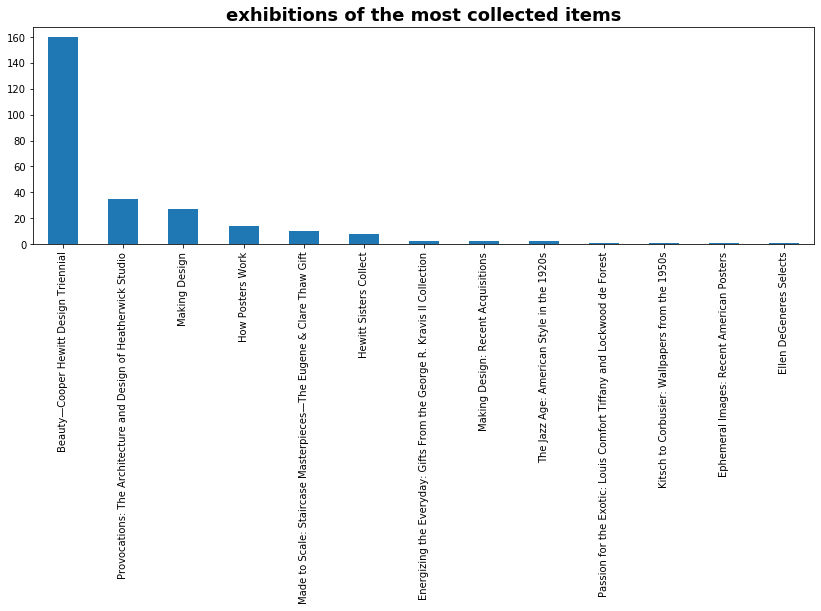

In [112]:
fig, ax = plt.subplots(figsize = (14,4))

top_exhibition = merged_date['exhibition_title'].value_counts()
top_exhibition.plot.bar(top_exhibition.index, y='exhibition_title', rot=0)
plt.xticks(rotation=90)
ax.set_title("Exhibition Title", size = 14)
plt.xticks(x=merged_date['exhibition_title'])
plt.title('exhibitions of the most collected items', fontdict={'fontweight': 'bold', 'fontsize':18})


In [111]:
merged_date['exhibition_title'].value_counts()
top_exhibition.to_frame()

,exhibition_title
Beauty—Cooper Hewitt Design Triennial,160
Provocations: The Architecture and Design of Heatherwick Studio,35
Making Design,27
How Posters Work,14
Made to Scale: Staircase Masterpieces—The Eugene & Clare Thaw Gift,10
Hewitt Sisters Collect,8
Energizing the Everyday: Gifts From the George R. Kravis II Collection,2
Making Design: Recent Acquisitions,2
The Jazz Age: American Style in the 1920s,2
Passion for the Exotic: Louis Comfort Tiffany and Lockwood de Forest,1
